In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 
import time

In [2]:
def Reach_eulerexplicite(t_0, t_f: float, D: list, f, u , x_0, n =None, h=None):
    """Implementing euler method on a pertubation scheme. Work well when the pertubation set is finite"""
    assert n is not None or h is not None, "precise a step or a number of steps"
    if n is not None: 
        h = (t_f - t_0)/n
    else: 
        n = int((t_f - t_0)/n)+1
    Timestep = [t_0 + i*h for i in range(n+1)]
    Timestep[n] = t_f
    Reach = [[x_0]]
    for i in range(n): 
        h = Timestep[i+1] - Timestep[i]
        new = [x+ h*f(x,u(Timestep[i]), d) for x in Reach[i] for d in D] 
        
        Reach.append(new)
    return Reach, Timestep

In [3]:
def eulerexplicite(t_0, t_f: float, f, u, d , x_0, n =None, h=None):
    """Implementing euler method on a pertubation scheme. Work well when the pertubation set is finite"""
    assert n is not None or h is not None, "precise a step or a number of steps"
    if n is not None: 
        h = (t_f - t_0)/n
    else: 
        n = int((t_f - t_0)/n)+1
    Timestep = [t_0 + i*h for i in range(n+1)]
    Timestep[n] = t_f
    Reach = [x_0]
    for i in range(n): 
        h = Timestep[i+1] - Timestep[i]
        new = Reach[-1]+ h*f(Reach[-1],u(Timestep[i]), d(Timestep[i]))
        Reach.append(new)
    return Reach, Timestep

In [4]:
# %timeit
# N = [5, 10, 20, 25]
# figure, ax= plt.subplots(2,2,figsize = (6,6))
# h=0
# j=0
# for n in N: 
#     Reach, Timestep = Reach_eulerexplicite(0, 1,np.linspace(0,0.2, 2) , lambda x,u,d: x+u+d, lambda t: np.exp(t)/(1+np.exp(t)) , x_0 =0, n =n, h=None)
#     for i in range(n): 
#         m = len(Reach[i])
#         ax[h][j].scatter([Timestep[i]]*m,Reach[i])
#     h+=int(j==1)
#     j = (j+1)%2
# plt.show()

# CDSM SYSTEM
We can simplfy our analysis to a discrete set of x and u and d. 

In [5]:
def sampling_increasing_sequence(N): 
    L= [0]
    for i in range(N-1): 
        L.append(L[-1]+np.random.lognormal())
    return L
def sampling_function(N, D): 
    """The goal is to randomly generates a function from T to the sets.
    We will be doing affine approximation of this function"""
    T = sampling_increasing_sequence(N)
    S = D[np.random.choice(len(D), size =N)]
    return T,S
def piecewise_affine(t,T,S):
    a = 0 
    b = len(T)-1
    if  (t >= T[-1]): 
        return S[-1]
    while (b-a)>1 :
        m = int((a+b)//2)
        if t >= T[m]:
            a = m
        else: 
            b=m
    h = S[a] + (S[b] - S[a])*(t-T[a])/(T[b] - T[a])
    return h
def sampling_stepfunction(N, D): 
    """The goal is to randomly generates a function from T to the sets.
    We will be doing affine approximation of this function"""
    S = D[np.random.choice(len(D), size =N)]
    return S
def step_function(t,h,S): 
    m = len(S)
    n = int(t/h)
    if n >= m: 
        return S[-1]
    return S[n]
def piecewise_step_function(t,h,S): 
    m = len(S)
    n = int(t/h)
    if n >= 0 and n < m: 
        s=(t-n*h)*(S[n + 1] - S[n])/h + S[n] 
    elif n >= m: 
        s = s[m]
    return s

In [6]:
T,S = sampling_function(6, np.linspace(0,0.2, 10).reshape((5,2)))

In [7]:
np.linspace(0,0.2, 10).reshape((5,2)),S

(array([[0.        , 0.02222222],
        [0.04444444, 0.06666667],
        [0.08888889, 0.11111111],
        [0.13333333, 0.15555556],
        [0.17777778, 0.2       ]]),
 array([[0.13333333, 0.15555556],
        [0.04444444, 0.06666667],
        [0.        , 0.02222222],
        [0.04444444, 0.06666667],
        [0.08888889, 0.11111111],
        [0.04444444, 0.06666667]]))

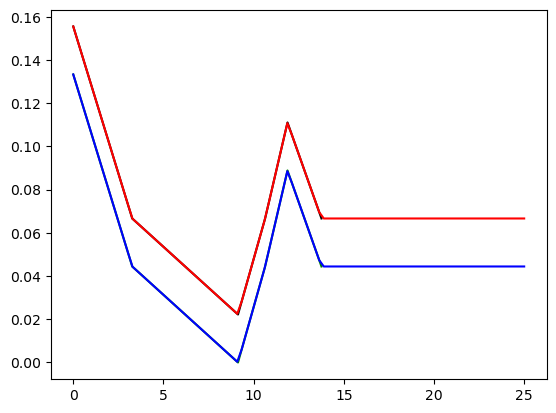

In [8]:
x= np.linspace(0,25,100)
y = np.array([piecewise_affine(t,T,S) for t in x])
fig = plt.figure()
plt.plot(T,S[:,0],"g", label="line_1")
plt.plot(T,S[:,1],"k", label="line_2")

plt.plot(x,y[:,0],"b", label="line_3")
plt.plot(x,y[:,1],"r", label="line_4")

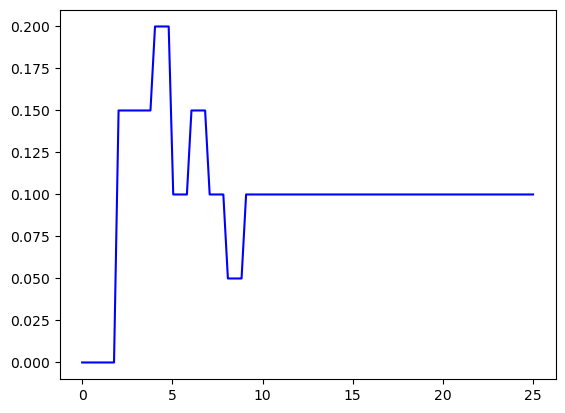

In [9]:
S= sampling_stepfunction(10, np.linspace(0,0.2, 5))
x= np.linspace(0,25,100)
h = 1 
y = [step_function(t,h,S) for t in x]
fig = plt.figure()

plt.plot(x,y,"b", label="line_2")

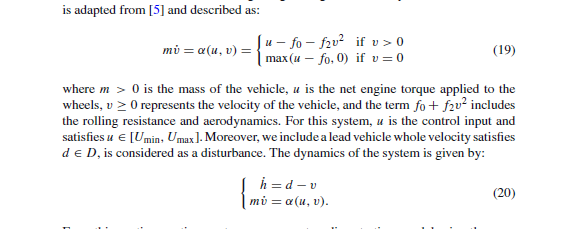
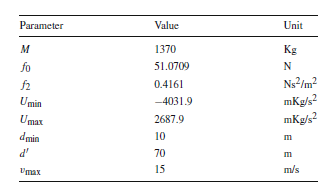

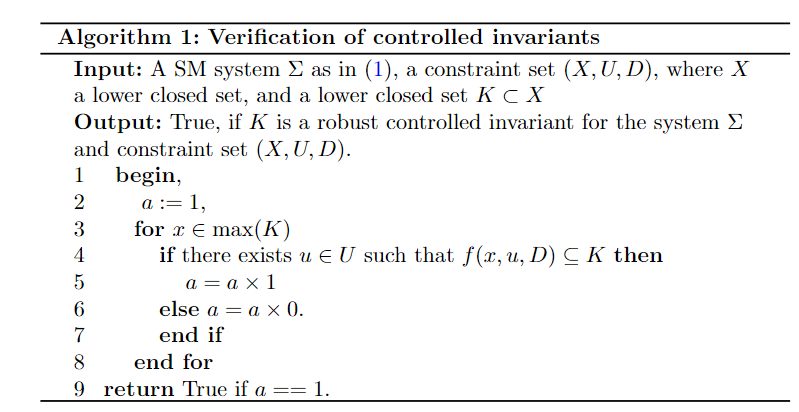

In [10]:
def Verif_contro_inv(max_k, U, D, T, N_step, N_test, N_euler, g, f):
    a =1
    Us = []
    if len(D)==1:
        d = lambda t: D[0]
        for x in max_k: 
            s = 0
            for i in range(N_test):
                S_U= sampling_stepfunction(N_step, U)
                h = T/N_step
                u = lambda t: step_function(t,h,S_U)
                b=0
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
                if b == 0:
                    s= 1
                    Us.append([S_U, h])
                    break
                a = a*s
        return a==1, Us
    for x in max_k: 
        s = 0
        for i in range(N_test):
            S_U= sampling_stepfunction(N_step, U)
            h = T/N_step
            u = lambda t: step_function(t,h,S_U)
            b = 0
            for j in range(N_test): 
                S_D =sampling_stepfunction(2*N_step, D)
                d = lambda t: step_function(t,h/2,S_D)
                
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =10*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                     b = b+1
            if b == 0:
                s= 1
                Us.append([S_U, h])
                break
        a = a*s
    return a==1, Us
                

In [12]:
def Verif_contro_inv_conti(max_k, U, D, T, N_step, N_test, N_euler, g, f):
    a =1
    Us = []
    if len(D)==1:
        d = lambda t: D[0]
        for x in max_k: 
            s = 0
            for i in range(N_test):
                S_U= sampling_stepfunction(N_step, U)
                h = T/N_step
                u = lambda t: step_function(t,h,S_U)
                b=0
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
                if b == 0:
                    s= 1
                    Us.append([S_U, h])
                    break
                a = a*s
        return a==1,Us
    for x in max_k: 
        s = 0
        for i in range(N_test):
            S_U= sampling_stepfunction(N_step, U)
            h = T/N_step
            u = lambda t: piecewise_step_function(t,h,S_U)
            b=0
            for j in range(N_test): 
                S_D = sampling_stepfunction(2*N_step, D)
                d = lambda t: piecewise_step_function(t,h/2,S_D)
                
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
            if b == 0:
                s= 1
                Us.append([S_U, h])
                break
        a = a*s
    return a==1, Us
def Verif_contro_inv_conti_dis(max_k, U, D, T, N_step, N_test, N_euler, g, f):
    a =1
    Us = []
    if len(D)==1:
        d = lambda t: D[0]
        for x in max_k: 
            s = 0
            for i in range(N_test):
                S_U= sampling_stepfunction(N_step, U)
                h = T/N_step
                u = lambda t: step_function(t,h,S_U)
                b=0
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
                if b == 0:
                    s= 1
                    Us.append([S_U, h])
                    break
                a = a*s
        return a==1,Us
    for x in max_k: 
        s = 0
        for i in range(N_test):
            S_U= sampling_stepfunction(N_step, U)
            h = T/N_step
            u = lambda t: piecewise_step_function(t,h,S_U)
            b=0
            for j in range(N_test): 
                S_D = sampling_stepfunction(2*N_step, D)
                d = lambda t: step_function(t,h/2,S_D)
                
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
            if b == 0:
                s= 1
                Us.append([S_U, h])
                break
        a = a*s
    return a==1, Us
def Verif_contro_inv_dis_conti(max_k, U, D, T, N_step, N_test, N_euler, g, f):
    a =1
    Us = []
    if len(D)==1:
        d = lambda t: D[0]
        for x in max_k: 
            s = 0
            for i in range(N_test):
                S_U= sampling_stepfunction(N_step, U)
                h = T/N_step
                u = lambda t: step_function(t,h,S_U)
                b=0
                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
                if b == 0:
                    s= 1
                    Us.append([S_U, h])
                    break
                a = a*s
        return a==1,Us
    for x in max_k: 
        s = 0
        for i in range(N_test):
            S_U= sampling_stepfunction(N_step, U)
            h = T/N_step
            u = lambda t: step_function(t,h,S_U)
            b=0
            for j in range(N_test): 
                S_D = sampling_stepfunction(2*N_step, D)
                d = lambda t: piecewise_step_function(t,h/2,S_D)

                Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = x, n =N_euler*N_step)
                k = [g(i) == 0 for i in Solu]
                if any(k):
                    b = b+1
            if b == 0:
                s= 1
                Us.append([S_U, h])
                break
        a = a*s
    return a==1, Us

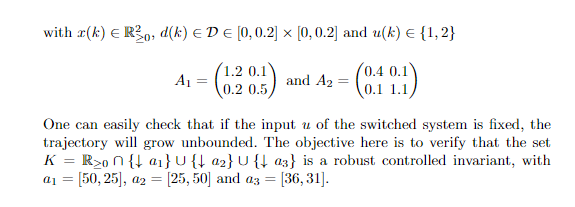

In [12]:
A_1 =np.array([[2,0.1],[0.2,2]])
np.linalg.eig(A_1)

(array([2.14142136, 1.85857864]),
 array([[ 0.57735027, -0.57735027],
        [ 0.81649658,  0.81649658]]))

In [13]:
%%time
max_k = np.array([[5, 2.5],[2.5, 5],[3.6, 3.1]])
U =np.array([1,2])
D = np.array([[0.2, 0.2]])
T = 50
N_step = 10
N_test = 1000
N_euler = 1000
A_1 =np.array([[2,0.1],[0.2,2]])

A_2 =np.array([[2,0.1],[0.1,2]]) 
def g(x): 
    return ((x[0]<= 5 and x[1] <= 2.5) or (x[0]<= 2.5 and x[1] <= 5) or (x[0]<= 3.6 and x[1] <= 3.1)) and (x[0]>=0 and x[1]>=0)
def f(x, u, d):
    if u == 1:
        h = np.dot(A_1,x.T).T + d 
    else: 
        h = np.dot(A_2,x.T).T + d 
    return h
Verif, Us = Verif_contro_inv(max_k, U, D, T, N_step, N_test, N_euler, g, f)

Wall time: 318 ms


In [14]:
for x in max_k:
    print(x, g(x)==0)

[5.  2.5] False
[2.5 5. ] False
[3.6 3.1] False


In [15]:
Verif

True

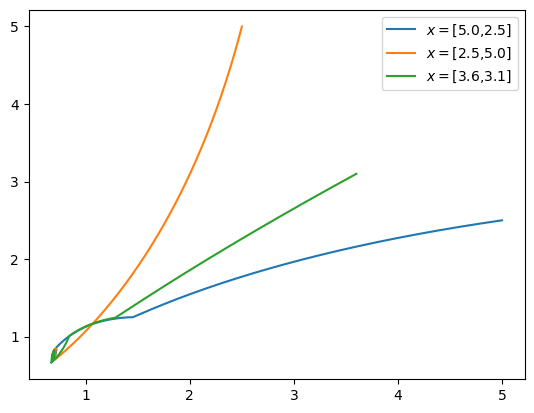

In [16]:
fig = plt.figure()
d = lambda t: D[0]
for i in range(3): 
    S_U, h = Us[i]
    u = lambda t: step_function(t,h,S_U)
    Solu,Timestep= eulerexplicite(t_0 = 0, t_f=T, f=f, u=u, d=d , x_0 = max_k[i], n =N_euler*N_step)
    plt.plot(np.array(Solu)[:,0], np.array(Solu)[:,1],'-', label=r'$x=[$'+ f"{max_k[i][0]}"+","+f"{max_k[i][1]}"+"$]$" )
plt.legend()

In [17]:
Us 

[[array([2, 1, 1, 1, 1, 2, 2, 2, 2, 2]), 5.0],
 [array([2, 2, 2, 1, 2, 1, 1, 2, 1, 1]), 5.0],
 [array([2, 1, 2, 2, 1, 2, 1, 2, 2, 1]), 5.0]]